In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('..')
import sea

In [2]:
# %% simulation parameters
param = {
    'MAX_RECURSION_LEVEL':  0, # 0 is myopic (necessary in high D)
    'EXPLORATION_PARAM':    0.0,
    'DECISION_PARAMETER':   1.0,
    'TOTAL_BLOCKS':         100,
    'CONSEC_BLOCKS':        2,
    'num_dims':             100,
    'num_values':           2,
    'coupling':             .3,
    'd':                    1.0,
    'report':               False,
    'NUM_TIMES':            5,
    'TRIAL_PER_BLOCK':      10,
}

param['prior_matrix'] = np.array([[1.0, 1.0]] * param['num_dims'])
param['prior_matrix'][0, 0] = .01
param['prior_matrix'][0, 1] = .01

In [3]:
# functions for computing utility:


def getSituationCost(KNOWN_VEC, param):
    '''function to calculate costs for a given KNOWN_VEC (see RMC.SituationValue)

    This function assumes equal costs for each query. Can be modified for
    tasks in which some tests are more costly than others, or when sampling costs
    are not independent.'''

    return np.sum(KNOWN_VEC) * 10


def dfActionVals(param):
    '''function to define utility table (e.g., table 1)

    When asym is True, this currently maximizes accuracy (i.e., correct=100
    utility units, incorrect=0 utility units).

    This function should be modified to reflect utility and cost associated
    with the final choice.'''

    m = np.diag([100] * param['num_values'])
    df = pd.DataFrame(index=['s%d' % a for a in range(param['num_values'])],
                      columns=['a%d' % a for a in range(param['num_values'])],
                      data=m)
    return df


param['getSituationCost'] = getSituationCost
param['dfActionVals'] = dfActionVals(param)

In [4]:
# %% STANDARD MODEL (ACTIVE SAMPLING)

model = sea.RMC(param)

overall_correct = np.zeros([param['TOTAL_BLOCKS']])
overall_sampled = np.zeros([param['TOTAL_BLOCKS']])

KNOWN = np.ones(model.NUM_DIMS).astype(int)
KNOWN[0] = 0    # the category label
QUERY = np.zeros(model.NUM_DIMS)
QUERY[0] = 1

dfC = pd.DataFrame(
    index=range(
        param['NUM_TIMES']), columns=range(
            param['TOTAL_BLOCKS']))
dfS = pd.DataFrame(
    index=range(
        param['NUM_TIMES']), columns=range(
            param['TOTAL_BLOCKS']))

for run_num in range(param['NUM_TIMES']):

    model.Reset()

    tr = 0
    for num_block in tqdm(range(param['TOTAL_BLOCKS']),
                          desc='run%d'%run_num):
        nS = 0
        nC = 0
        for i in range(param['TRIAL_PER_BLOCK']):

            tr += 1

            STIM = np.random.random(model.NUM_DIMS)
            STIM = STIM > .5
            if STIM[1]:  # category label.
                STIM[0] = 1
            else:
                STIM[0] = 0

            STIM = STIM.astype(int)

            tempN = model.PresentStimulus(STIM, KNOWN)

            SAMPLED_KNOWN = np.zeros(model.NUM_DIMS)
            SAMPLED_KNOWN[tempN] = 1

            nS += len(tempN)
            overall_sampled[num_block] += len(tempN)
            vC = model.ResponseCorrectProb(STIM, SAMPLED_KNOWN)
            nC += vC
            overall_correct[num_block] += vC
            model.Learn(STIM, SAMPLED_KNOWN, QUERY)

        dfS.loc[run_num, num_block] = nS / param['TRIAL_PER_BLOCK']
        dfC.loc[run_num, num_block] = nC / param['TRIAL_PER_BLOCK']

overall_correct /= (param['TRIAL_PER_BLOCK'] * param['NUM_TIMES'])
overall_sampled /= (param['TRIAL_PER_BLOCK'] * param['NUM_TIMES'])



run4: 100%|██████████| 100/100 [02:21<00:00,  1.20s/it]


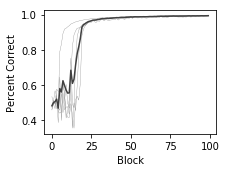

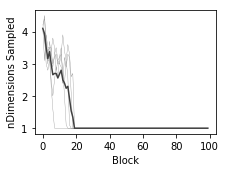

In [7]:
# figures

bk = 1
col = ['b', 'k'][bk]

plt.figure(figsize=(3.25, 2.5))
plt.plot(dfC.T, color=['#b3ccff', '#808080']
         [bk], linewidth=.3)  # ,legend=False)
mn = dfC.mean()
plt.plot(mn, ['#0000ff', '#404040'][bk])
plt.xlabel('Block')
plt.ylabel('Percent Correct')
plt.tight_layout()
plt.show();plt.pause(.01)

plt.figure(figsize=(3.25, 2.5))
plt.plot(dfS.T, color=['#b3ccff', '#808080']
         [bk], linewidth=.3)  # ,legend=False)
mn = np.mean(dfS, axis=0).values
plt.plot(mn, ['#0000ff', '#404040'][bk])
plt.yticks([1, 2, 3, 4])
plt.xlabel('Block')
plt.ylabel('nDimensions Sampled')
plt.tight_layout()
plt.show();plt.pause(.01)
